# Disaster Tweets: Predicting Occurences of Real Disasters

Twitter has found use recently in many analytics problems as many people from around the world are able to report things before reputable news outlets can verify them. However, it is also the case that people lie or use language that implies a disaster in a metaphorical sense (eg. *we're going to cause an earthquake tonight*). The purpose of this Kaggle competition is to determine which bracket these tweets fall into based on their hand classified tweets.

In [644]:
import numpy as np
import pandas as pd
import sys
from sys import path

#plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns
import cufflinks as cf
import plotly
import plotly.express as px
import plotly.figure_factory as ff
import plotly.graph_objects as go

#machine learning
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, plot_confusion_matrix, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
import shap #model explainability tool

#stats 
from scipy.stats import skew

#nlp
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import word_tokenize
#Lemmatizing the words to reduce to root form
from nltk.stem import WordNetLemmatizer
#pos tagging to be able to put words in their root form
from nltk import pos_tag
from textblob import TextBlob #useful for sentiment analysis and pos tagging
import string

#useful for a function we build later
from math import isnan

from collections import Counter 

sys.path.append('./nlp-getting-started/')

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /Users/eh115/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/eh115/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/eh115/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


## 0.1 Importing the training tweets and some cleaning

Our dataset has $5$ columns:
 - Id: A unique identifier attached to the tweet.
 - keyword: A particular keyword from the tweet that might have been important or pertaining to a disaster (may be blank).
 - location: Location of the sender (may be blank).
 - text: The text contained in the tweet.
 - target: The class of the tweet. *Real Disaster* = $1$ and *False Alarm* = $0$
 
In the training set we have $7613$ tweets. 

There are $222$ unique keywords, including NaN. Examples of some keywords: *avalanche*, *damage*, *cyclone*, *siren* etc. 

There are $3342$ unique locations in the training set, these are city names such as *London*, *Birmingham*, *Vancouver, Canada* etc.
 

In [542]:
#Will split into training and test sets after
tweets = pd.read_csv('./nlp-getting-started/train.csv')
tweets.columns, len(tweets)

(Index(['id', 'keyword', 'location', 'text', 'target'], dtype='object'), 7613)

In [420]:
#Importing the test tweets: these do not have a target label as they are for a kaggle competition
test_tweets = pd.read_csv('./nlp-getting-started/test.csv')

In [421]:
#Observing the dataframe structure
tweets.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation orders in California",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1


In [422]:
tweets['keyword'].unique();
tweets['location'].unique();

In [546]:
#Previewing some tweets
print('''This is a preview of the first 10 tweets, all of which correspond to real disasters:
      ''')
for i in range(20):
    print(('%d. '+tweets['text'][i]) % i)

This is a preview of the first 10 tweets, all of which correspond to real disasters:
      
0. our deeds are the reason of this earthquake may allah forgive us all
1. forest fire near la ronge sask. canada
2. all residents asked to shelter in place are being notified by officers. no other evacuation or shelter in place orders are expected
3. 13000 people receive wildfires evacuation orders in california 
4. just got sent this photo from ruby alaska as smoke from wildfires pours into a school 
5. rockyfire update    california hwy. 20 closed in both directions due to lake county fire   cafire wildfires
6. flood disaster heavy rain causes flash flooding of streets in manitou  colorado springs areas
7. i am on top of the hill and i can see a fire in the woods.
8. there is an emergency evacuation happening now in the building across the street
9. i am afraid that the tornado is coming to our area.
10. three people died from the heat wave so far
11. haha south tampa is getting flooded hah  

In [547]:
print('''This is a preview of the first 10 tweets all of which correspond to false alarms:
      ''')

counter = 1
for txt in tweets[tweets['target']==0]['text'][0:30]:
    print(('%d. '+txt) % counter)
    counter += 1


This is a preview of the first 10 tweets all of which correspond to false alarms:
      
1. what is up man.
2. i love fruits
3. summer is lovely
4. my car is so fast
5. what a goooooooaaaaaal.
6. this is ridiculous.
7. london is cool  
8. love skiing
9. what a wonderful day.
10. lol
11. no way.i can't eat that shit
12. was in nyc last week.
13. love my girlfriend
14. cooool :
15. do you like pasta.
16. the end.
17. we always try to bring the heavy. metal rt   
18. crying out for more. set me ablaze
19. on plus side look at the sky last night it was ablaze   
20.  mufc they've built so much hype around new acquisitions but i doubt they will set the epl ablaze this season.
21. ablaze for you lord :d
22. check these out:             nsfw
23. on the outside you're ablaze and alive but you're dead inside
24. had an awesome time visiting the cfc head office the ancop site and ablaze. thanks to tita vida for taking care of us .
25. soooo pumped for ablaze . 
26. i wanted to set chicago ablaze

### 0. 2 Cleaning the text data using the Regular Expressions (re) library and strings

In [545]:
import re

def clean_tweet(text):
    # encode tweets as utf-8 strings
#     text = text.decode('utf-8')
    # remove commas in numbers (else vectorizer will split on them)
    text = re.sub(r',([0-9])', '\\1', text)
    # sort out HMTL formatting of &
    text = re.sub(r'&amp', 'and', text)
    #make sure there is a space after full stop
    text = re.sub(r'(\w)\.(\w)','\\1.  \\2',text) ### seems to have decreased accuracy
    #remove co links
    text = re.sub(r'co/\w{6,12}','',text)
    #remove initial quotation marks
    text = re.sub(r'\s(\'|")',' ',text)
    #remove final quotation marks
    text = re.sub(r'(\'|")\s',' ',text)
    #replace contractions with is
    text = re.sub(r'\'s',' is',text)
    #remove hashtags
    text = re.sub(r'#','',text)
    #replace exclamation marks and question marks with full stop
    text = re.sub(r'[!?]+','.',text)
    #replace repetitions of full stops with just a singular one
    text = re.sub(r'\.+','.',text)
    #lower case
    text = text.lower()
    #remove twitter handles
    text = re.sub(r'@[\w_]{1,15}','',text) #increases unigram model accuracy, decreases bigram model accuracy
    #remove brackets
    text = re.sub(r'(\(|\))','',text)
    #lol and variants, as it is likely a strong signifier that the tweet doesn't correspond to a disaster
    text = re.sub(r'lo+l','lol',text)
    #remove contractions
    text = re.sub(r'i\'m','i am',text)
    #remove colons as I will keep them after for times
#     text = re.sub(r':\s+','',text)
    #remove dates and replace with text 'date'
#     text = re.sub(r'(\d\d?)(/|-)(\d\d?)(/|-)(\d\d\d\d)','$5',text)
    # strip urls
    return re.sub(r'http[s]{0,1}://[^\s]*', '', text)

tweets['text'] = tweets['text'].map(clean_tweet)


#temporary whitelist before using the re library, returns tweets with only the permitted characters and lowercase
def whitelisted(text):
    whitelist = string.ascii_letters + string.digits + ' ' + '\'' + '.' + ':' + '$£' #last two for time and money
    new_str = ''
    for char in text:
        if char in whitelist:
            new_str += char
        else:
            new_str += ' '
    
    return new_str.lower()

tweets['text'] = tweets['text'].map(whitelisted)

###  Observations about the text:

The text is likely to contain typos or misspellings as can be seen with the word "*gooooooaaaaaaal*". The vocabulary we construct will be unlikely to contain such words due to their infrequency.

Tweeters often use # (hashtags) to indicate an important or relevant topic. This would likely be removed in standard tokenization, but it might be worth trying to retain the hashtag as they are words the tweeter wants to highlight. **Consider adding another column to the dataframe that only includes hashtags**

## 1 Visualising occurences of keywords, locations, length and sentiments

Though this is a natural language task, there will be much hidden data and correlations between the included information in the auxiliary data. For example, many tweets involving the mention of california also mention wildfires, which of course were a significant story for a prolonged period. Therefore we might expect mentions of California to be more associated with disasters than other places (note that this might not be true). 

In this section, we will provide a basic analysis of the additional data.

### 1.1 Keyword Information
As we see, the most common word is *fatalities* with 45 counts (NaN excluded). The least used keyword is *radiation emergency* with 9 counts. However, for the keywords column the data has a very small gradient, with many keywords appearing a similar number of times.

The most frequent location of tweets are *USA* for country and *New York* for cities. Interestingly, *London* comes in at 2nd in the list of cities, but *UK* comes in 3rd place for countries (combined totals).

In [450]:
#creating a keyword dataframe that will let us plot the proportion of the most common keywords belonging 
#to real disasters
num_unique = len(tweets['keyword'].unique())
keyword_df = pd.DataFrame(tweets['keyword'].unique(), columns=['keyword'])
keyword_df['keyword_frequency'] = [0] * num_unique
keyword_df['disaster_frequency'] = [0] * num_unique
keyword_df.drop(axis=0,labels=0,inplace=True) #drop NaN keyword entry


#value counts of keywords
keyword_counts = tweets['keyword'].value_counts()
keyword_counts_dis = tweets['keyword'][tweets['target']==1].value_counts()

#filling in the value count data
for keyword in keyword_df['keyword']:
    keyword_df['keyword_frequency'][keyword_df['keyword']==keyword] = keyword_counts[keyword]

#not all keywords appear in the disaster counts
for keyword in keyword_counts_dis.index:
    keyword_df['disaster_frequency'][keyword_df['keyword']==keyword] = keyword_counts_dis[keyword]

In [451]:
#sort by keyword_frequency and disaster_frequency
ranked_keywords = keyword_df.sort_values(by=['keyword_frequency','disaster_frequency'],
                                         ascending=False,ignore_index=True)

#Plotting data 
top_counts = ranked_keywords['keyword_frequency'][0:20].tolist()
top_words = ranked_keywords['keyword'][0:20].tolist()
top_disaster_subcounts = ranked_keywords['disaster_frequency'][0:20].tolist()
top_non_disaster_subcounts = np.array(top_counts) - np.array(top_disaster_subcounts)

In [514]:
#plotting a bar chart of the most frequent keywords, and the proportion that correspond to disasters
fig = go.Figure(go.Bar(x=top_words,y=top_non_disaster_subcounts,name='Non-Disaster Counts',opacity=1,marker_color='dodgerblue'))
fig.add_trace(go.Bar(x=top_words,y=top_disaster_subcounts,name='Disaster Counts',opacity=0.95,marker_color='red'))
fig.update_layout(barmode='stack',title='20 Most Frequent Keywords',yaxis_title='Frequency',
                  xaxis_title='',title_x=0.3)
fig.show()

### 1.2 Location Data

There are 3342 unique locations included in the training data. However, many of the locations relate to the same place, as can be seen by the figure below. This includes alternate names (eg. USA versus US versus United States) or even sub-locations (eg. London and UK or California and USA).

When accounting for alternate names, the three most prolific countries with tweets in the training data are the US, UK and Canada - i.e. three of the largest anglophone countries population-wise. Nigeria, India and Australia round out the next three, each of which has English as one of the main languages. In fact, many of the top 20 most frequent locations are situated in the United States, such as California (and California, USA) and Los Angeles.

Due to the many alternative names for similar locations, it is difficult to use the location data in a significant way, as many would have to be manually identified. I attempt this in a minor way using text-matching after creating a baseline language model.

**Optional - Look into some top locations and their distribution of disaster tweets vs non disaster tweets

In [453]:
#number of unique locations in the location data
len(tweets['location'].unique())

3342

In [501]:
top_loc_counts = [tweets['location'].value_counts()[i] for i in range(20)]
top_locs = tweets['location'].value_counts().index.tolist()[0:20]
top_locs_counts_disasters = tweets['location']

#plotting a bar chart of the frequency of each location tag
fig = px.bar(top_loc_counts,x=top_locs,y=top_loc_counts,title='Frequency of Locations in the Training Data'
             ,color_discrete_sequence=['dodgerblue'],opacity=0.85) 
#color=top_loc_counts,color_continuous_scale=px.colors.sequential.Viridis
fig.update_layout(yaxis_title='Frequency',title_x=0.5,xaxis_title='',coloraxis_showscale=False)
fig.show()

### 1.3 Distribution of the Length of Tweets

Tweets have an enforced maximum character limit of around 280 characters (used to be 140). Within that limit, arbitrarily many words can be used. We might expect the distributions for the two samples to be different, with disaster tweets more likely originating from news stories and therefore more likely to have fewer words. 

In actuality, this is not what we observe. The mean, standard deviation and inter-quartile ranges for the two distributions are very similar, with disaster tweets being slightly more centred around the mean length. The non-disaster tweets have an approximately 27% higher skew than their disaster-related counterparts, though both skews are small and the distributions are roughly symmetric.

In [515]:
#finding the tweet word count distributions for disaster and non-disaster related tweets
length_distribution = pd.DataFrame(tweets[['text','target']],columns=['text','target'])

#filling in the length of each tweet
length_distribution['length_of_tweet'] = length_distribution['text'].map(lambda x: len(x.split()))

#re-order the columns
length_distribution = length_distribution[['text','length_of_tweet','target']]

#distribution of disaster and non-disaster tweets
length_distribution['disaster_length'] = length_distribution['length_of_tweet'][length_distribution['target']==1]
length_distribution['non_disaster_length'] = length_distribution['length_of_tweet'][length_distribution['target']==0]

#Plot the histograms using cufflinks
length_distribution_fig = length_distribution[['non_disaster_length','disaster_length']].iplot(asFigure=True,
                            kind='histogram',xTitle='Number of Words in Tweet',yTitle='Occurences',
                                title='Tweet-Length Distribution',color=['brightred','dodgerblue'],opacity=0.9)
length_distribution_fig.update_layout(title_x=0.43)
length_distribution_fig.show()

In [456]:
#some basic statistics about the sample distributions
length_distribution[['disaster_length','non_disaster_length']].describe()

,disaster_length,non_disaster_length
count,3271.000000,4342.000000
mean,14.365637,13.998158
std,5.380753,6.392520
min,1.000000,1.000000
25%,10.000000,9.000000
50%,14.000000,14.000000
75%,18.000000,19.000000
max,32.000000,32.000000


In [537]:
print('The skew of the disaster_length distribution is %.3f' % 
      (skew(length_distribution[length_distribution['target']==1]['length_of_tweet'].tolist()) ) )

print('The skew of the non_disaster_length distribution is %.3f' % 
      (skew(length_distribution[length_distribution['target']==0]['length_of_tweet'].tolist()) ) )

The skew of the disaster_length distribution is 0.156
The skew of the non_disaster_length distribution is 0.198


### 1.4 Sentiment Analysis

Using TextBlob allows us to easily extract the polarity (between [-1,1]) and subjectivity (between [0,1]), where the former indicates positivity or negativity in the statement, and the latter attempts to determine whether a statement is factual or opinionated.

Looking at a few examples of the most positive and negative tweets in terms of polarity, we can see that the labelling of disaster and non-disaster tweets isn't perfect, with some tweets appearing with both labels (eg. **"fettilootch is slanglucci oppressions greatest danger coming soon the album"** and **"ashes 2015: australia   s collapse at trent bridge among worst in history: england bundled out australia for 60"**). The polarity score seemingly does a good job of analysing the extremes from these few examples, though some such as the first example (fettilootch...) appear neutral rather than having a maximum positivity rating.

From a basic statistical perspective, both disaster related tweets and non-disaster related tweets have the same minimum and maximum for polarity and subjectivity, with both also strongly peaked around zero. However, tweets labelled a non-disaster have greater means in polarity and subjectivity, with the former also having positive skew. The mean polarity of the disaster tweets is effectively zero, suggesting the news is often delivered in a neutral tone.

In [489]:
#creating a new dataframe to store the polarity and subjectivity values
sentiment_df = tweets[['text','target']]

#using TextBlob to generate sentiment values
sentiment_df['polarity'] = sentiment_df['text'].map(lambda x: TextBlob(x).sentiment[0])
sentiment_df['subjectivity'] = sentiment_df['text'].map(lambda x:  TextBlob(x).sentiment[1])

#reorder the columns
sentiment_df = sentiment_df[['text','polarity','subjectivity','target']]

pd.set_option('display.max_colwidth', -1)

sentiment_df.head();

In [473]:
#most negative polarity tweets for disaster and non-disasters
print('Most Negative Disaster Related Tweets \n')
print(sentiment_df[sentiment_df['polarity'] == -1][sentiment_df['target']==1]['text'][5:10]) #first few - same news 
print('\n \n Most Negative Non-Disaster Related Tweets \n')
print(sentiment_df[sentiment_df['polarity'] == -1][sentiment_df['target']==0]['text'][3:10])

Most Negative Disaster Related Tweets 

162     omg horrible accident man died in wings of airplane.                                                                    
454     horrific attack on wife by muslim in italy    liveleak news                                                             
1164    ashes 2015: australia   s collapse at trent bridge among worst in history: england bundled out australia for 60 .       
1640    . the pain of those seconds must have been awful as her heart burst and her lungs collapsed and there was no air and.   
2410     update  no passenger metro train derails causing terrible delays this morning: a derailed train is causing a hell      
Name: text, dtype: object

 
 Most Negative Non-Disaster Related Tweets 

869     no kinda in it that shii nasty blood. no pun intended                                                                        
1186    ashes 2015: australia   s collapse at trent bridge among worst in history: england bundled out aust

In [471]:
#most positive polarity tweets for disaster and non-disasters
print('Most Positive Disaster Related Tweets \n')
print(sentiment_df[sentiment_df['polarity'] == 1][sentiment_df['target']==1]['text'].head()) 
print('\n \n Most Positive Non-Disaster Related Tweets \n')
print(sentiment_df[sentiment_df['polarity'] == 1][sentiment_df['target']==0]['text'].head(8))

Most Positive Disaster Related Tweets 

2040     fettilootch is slanglucci oppressions greatest danger coming soon the album                                            
3530    rt patrickjbutler: excellent damiengayle eyewitness account of kids company closure: you drop the bomb and expect       
3807    jacksonville fire and  rescue engine 58   awesome truck.   official jade fl.    via                                     
4819    rt owenrbroadhurst rt juanmthompson: at this hour 70 yrs ago one of the greatest acts of mass murder in world hist      
6291    doves   the storm   greatest denier electric proms pt4                                                                  
Name: text, dtype: object

 
 Most Positive Non-Disaster Related Tweets 

23      what a wonderful day.                                                                                                                 
47      building the perfect tracklist to life leave the streets ablaze                           

In [462]:
#creating the distributions for polarity
sentiment_df['disaster_polarity'] = sentiment_df[sentiment_df['target']==1]['polarity']
sentiment_df['non_disaster_polarity'] = sentiment_df[sentiment_df['target']==0]['polarity']

#plotting the distributions
polarity_fig = sentiment_df[['non_disaster_polarity','disaster_polarity']].iplot(asFigure=True,kind='histogram',
                                                color=['brightred','dodgerblue'],bins=40,title='Polarity of Tweets',
                                                                opacity=0.85,xTitle='Polarity',yTitle='Counts')
polarity_fig.update_layout(title_x=0.43)

polarity_fig.show()

In [463]:
#creating the distributions for subjectivity
sentiment_df['disaster_subjectivity'] = sentiment_df[sentiment_df['target']==1]['subjectivity']
sentiment_df['non_disaster_subjectivity'] = sentiment_df[sentiment_df['target']==0]['subjectivity']

#plotting the distributions
subjectivity_fig = sentiment_df[['non_disaster_subjectivity','disaster_subjectivity']].iplot(asFigure=True,
                                                kind='histogram',color=['brightred','dodgerblue'],bins=40,
                                        title='Subjectivity of Tweets',xTitle='Subjectivity Score',yTitle='Counts')
subjectivity_fig.update_layout(title_x=0.43)

subjectivity_fig.show()

In [488]:
#checking the basic statistics for polarity and subjectivity
sentiment_df[['disaster_polarity','non_disaster_polarity','disaster_subjectivity','non_disaster_subjectivity']].describe()

,disaster_polarity,non_disaster_polarity,disaster_subjectivity,non_disaster_subjectivity
count,3271.000000,4342.000000,3271.000000,4342.000000
mean,0.018325,0.067202,0.267554,0.322322
std,0.235443,0.272367,0.315220,0.329214
min,-1.000000,-1.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.100000,0.269338
75%,0.075000,0.172064,0.500000,0.578472
max,1.000000,1.000000,1.000000,1.000000


## Basic word analysis

Questions to answer: How many words on average does a tweet have, What are the most common words, What is the word distribution for the 100 most common words, Word Cloud?

Importantly, we should also know how these keywords correlate with the target label. For example, is the word 'blast' found more often in non-emergency tweets than emergency tweets? What we would find from this is the class imbalance. If a word was involved in a disaster 80% of the time, then a basic model could get a high recall by always associating that word with a disaster target label. However, as it would throw up a lot of false positives, it would have low precision.

There are 222 keywords, including NaN, so we will only plot the top and bottom 20 ratios, as well as those middling ones.

In [68]:
#Analysing class imbalance for all relevant keywords

keywords = tweets['keyword'].unique()
keyword_target_fraction = {keyword: (tweets[tweets['keyword']== keyword]['target'].sum()/len(tweets[tweets['keyword']== keyword])) for keyword in keywords}
keyword_target_fraction;

#Need to sort the keyword_target_fraction dictionary by ratio. 
keyword_target_fraction_list = [[k, v] for (k,v) in keyword_target_fraction.items()]

keyword_target_fraction_list.sort(key=lambda x: x[1])

#remove the NaN row
key_target_fractions = keyword_target_fraction_list[1:]

#showing the list
key_target_fractions;

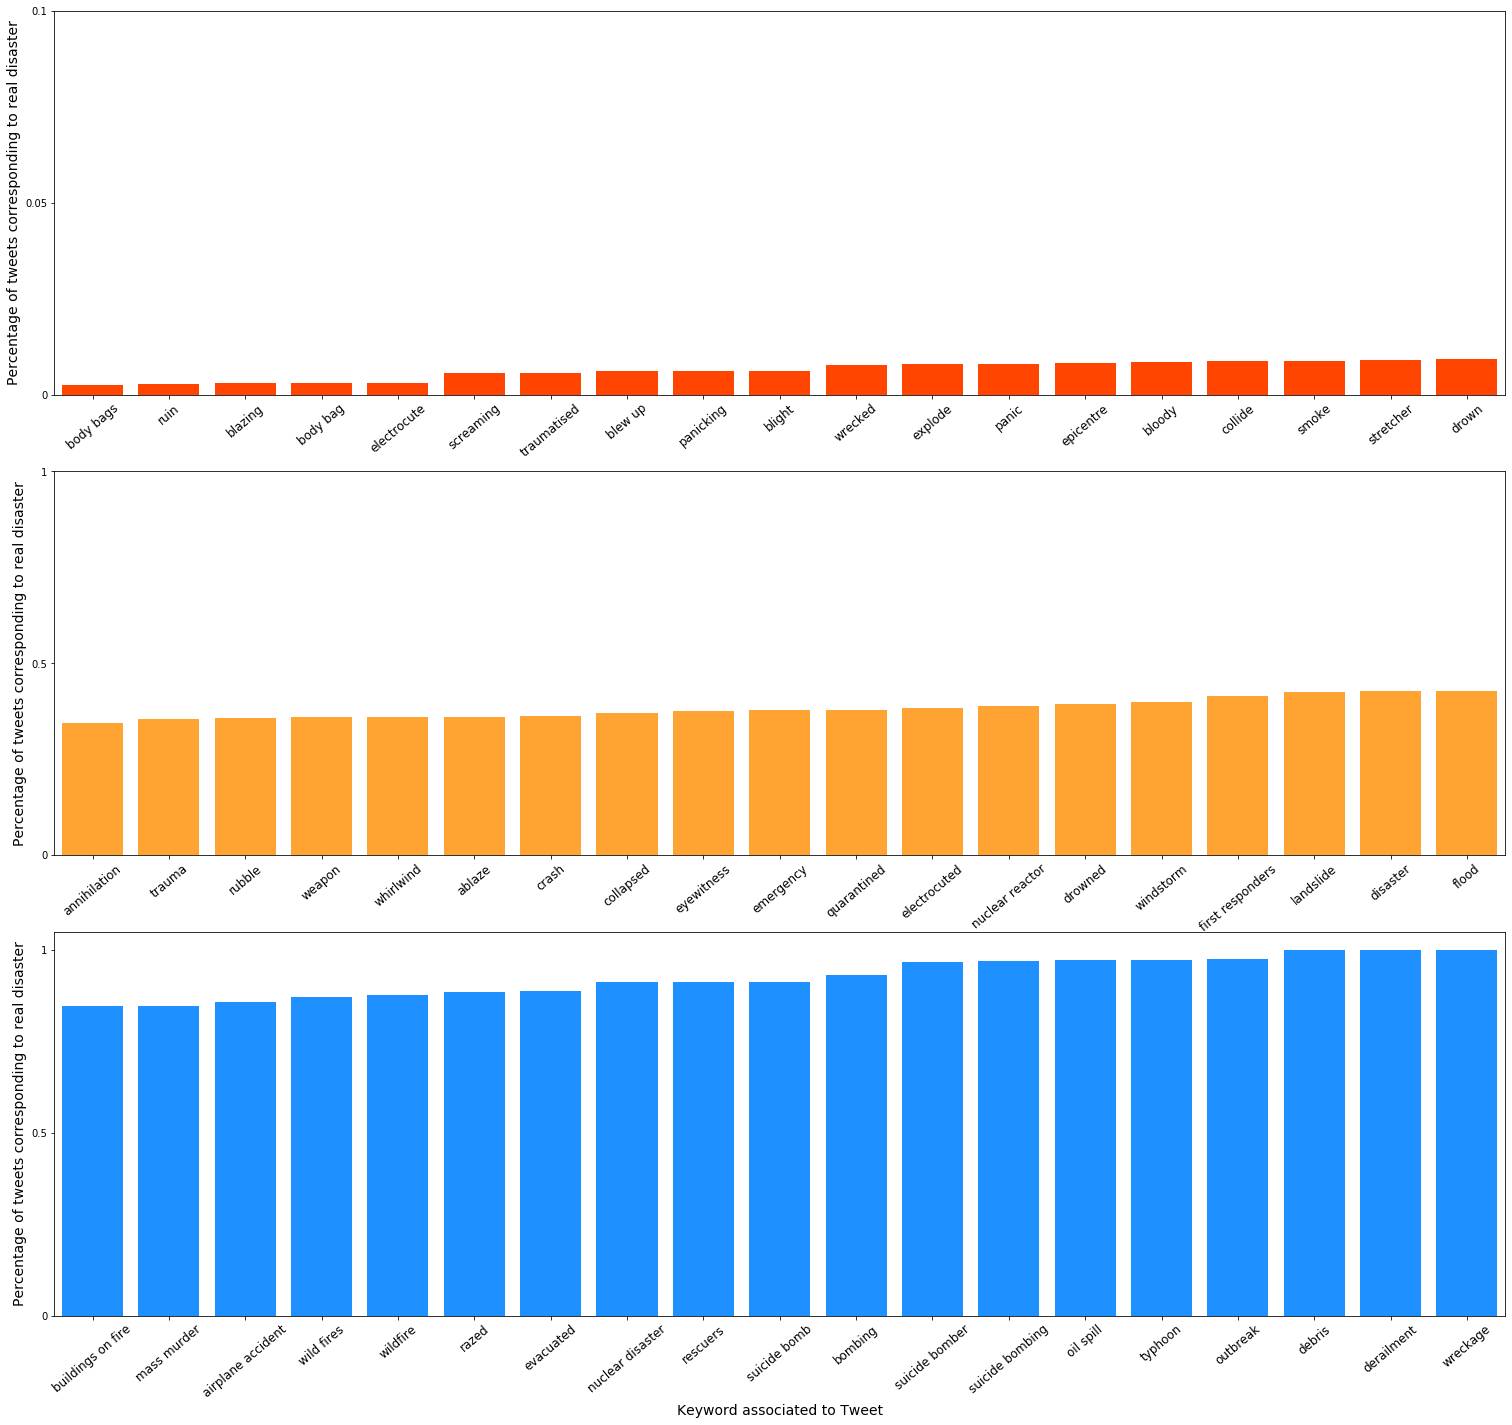

In [69]:
#Plotting the fraction of real disasters for each keyword
bottom_20 = np.array(key_target_fractions)[:,1:][0:20].flatten().astype(float)
top_20 = np.array(key_target_fractions)[:,1:][-20:].flatten().astype(float)
middle_20 = np.array(key_target_fractions)[:,1:][100:120].flatten().astype(float)

#Some names need to be cleaned due to formatting
bottom_20_names = np.array(key_target_fractions)[:,0:1][0:20].flatten()
bottom_20_names = [name.replace('%20',' ') for name in bottom_20_names]

top_20_names =  np.array(key_target_fractions)[:,0:1][-20:].flatten()
top_20_names = [name.replace('%20',' ') for name in top_20_names]

middle_20_names =  np.array(key_target_fractions)[:,0:1][100:120].flatten()
middle_20_names = [name.replace('%20',' ') for name in middle_20_names]


fig, ax = plt.subplots(figsize=(26,24), nrows = 3)

ax[0].bar([i for i in range(20)],bottom_20,color='orangered')
ax[0].set_xticks([i for i in range(20)])
ax[0].set_xticklabels(bottom_20_names,rotation=40,fontsize=12)
ax[0].set_yticks([0,0.5,1])
ax[0].set_yticklabels([0,0.05,0.1])
ax[0].set_ylabel('Percentage of tweets corresponding to real disaster',fontsize = 14)
#ax[0].set_xlabel('Keyword associated to Tweet',fontsize = 14)
ax[0].set_xlim([0.5,19.5])

ax[2].bar([i for i in range(20)],top_20,color='dodgerblue')
ax[2].set_xticks([i for i in range(20)])
ax[2].set_xticklabels(top_20_names,rotation=40,fontsize=12)
ax[2].set_yticks([0,0.5,1])
ax[2].set_yticklabels([0,0.5,1])
ax[2].set_ylabel('Percentage of tweets corresponding to real disaster',fontsize = 14)
ax[2].set_xlabel('Keyword associated to Tweet',fontsize = 14)
ax[2].set_xlim([0.5,19.5])

ax[1].bar([i for i in range(20)],middle_20,alpha=0.8,color='darkorange')
ax[1].set_xticks([i for i in range(20)])
ax[1].set_xticklabels(middle_20_names,rotation=40,fontsize=12)
ax[1].set_yticks([0,0.5,1])
ax[1].set_yticklabels([0,0.5,1])
ax[1].set_ylabel('Percentage of tweets corresponding to real disaster',fontsize = 14)
#ax[1].set_xlabel('Keyword associated to Tweet',fontsize = 14)
ax[1].set_xlim([0.5,19.5])
plt.show()

In [18]:
#Plot the tweet length distribution

**Observations**

- There are a few surprises hidden here. For example, most uses of the phrase 'body bag' do not correspond to an instance of a disaster. This is quite odd, as the other words in the bottom 20 can at least be used in other examples. My experience suggests it is rare to see body bags outside of a disaster setting.

- All phrases in the top 20 suggest real disasters and are therefore heavily imbalanced. Interestingly, typhoon has a very strong correlation with a real disaster, whereas the closely related word whirlwind, seemingly has a much smaller association with disasters.

Lets peer into these examples some more.

In [19]:
#Printing 10 tweets associated to the body bags keyword

def tweets_for_keyword(n_tweets,keyword):
    """
    n_tweets: int, number of tweets to be printed
    keyword: string, must be a string from the tweets dataframe
    """
    count = n_tweets
    for tweet in tweets['text'][tweets['keyword'] == keyword]:
        print(tweet + '\n')
        count += -1
        if count < 0:
            break

tweets_for_keyword(10,'body%20bags')

  when you call to report dangerous activity tell em to have body bags on arrival.

micom 2015 summer contrast candy color bowknot cross body tote shoulder bags for womengirls with micom zip po   

hobo hobo vintage shira convertible b    $238.  00 bestseller   

child shoulder bags pvc shoulder book bag cartoon cross body bags for girls      

womens buckle casual stylish shoulder handbags pockets cross body bags green   

ain't no bags in the trunk it is a body

bestseller. fossil dawson mini cross body bag es    $98.  00   

    appears to already be arriving in ridah in body bags.

the body bags has a show on 08 07 2015 at 07:30 pm   tremont music hall in charlotte nc    concert

body bags.   

you know you hate your body when you buy 2 bags of chips and a variety pack of fruit snacks and a redbull as a snack



**Observation**

What we see is that many instances of the words 'body' and 'bag' appearing together, are often to do with fashion or the words are separated.

### Further cleaning the data

As we can see in some of the prior examples, dates as well as prices appear. We will remove dates and prices, though an interesting thing to look at would be the appearance of prices in tweets and their target label. I suspect no prices appear in real disaster tweets, which would remove many cases.

### Word tokenization, lemmatization, removal of stop words and part of speech tagging

Need to remove unwanted punctuation

In [20]:
def tokenizer(df,):
    """
    df: pandas dataframe. Data type must be string format.
    """
    tokenized_list = []
    for text in df:
        tokenized_list.append(word_tokenize(text))
    
    return tokenized_list



In [21]:
#coming up with a less harsh custom stop words list by eliminating some from stop_words
custom_stop = ['i','me','my','myself','we','our','ours','ourselves','you',"you're","you've","you'll","you'd",'your',
'yours','yourself','yourselves','he','him','his','himself','she',"she's",'her','hers','herself','it',"it's",'its',
'itself','they','them','their','theirs','themselves','whom','this','that',"that'll",'these','those','am','is','are',
'was','were','be','been','being','have','has','had','having','do','does','did','doing','a','an','the','and','but',
'if','or','because','as','of','with','about','into','to','from','up','in','out','on','off','further',
'then','once','there','any','both','each','other','some','such','no','nor','not','only','own','same','so','than',
'too','can','will','just','don',"don't",'should',"should've",'now','ain','aren',"aren't",'couldn',"couldn't",'didn',
"didn't",'doesn',"doesn't",'hadn',"hadn't",'hasn',"hasn't",'haven',"haven't",'isn',"isn't",'ma','mightn',"mightn't",'mustn',
"mustn't",'needn',"needn't",'shan',"shan't",'shouldn',"shouldn't",'wasn',"wasn't",'weren',"weren't","won't",'wouldn',
"wouldn't"]


#tokenize and remove stop words
def stop_word_tokenize(tweet_list,stops):
    tokenized_stop_removed = []
    temp_list = []
    for sublist in tweet_list:
        temp_list = word_tokenize(sublist)
        temp_list = [word for word in temp_list if not word in stops]
        tokenized_stop_removed.append(temp_list)
    return tokenized_stop_removed

In [22]:
def wordnet_pos(word):
    #Function to convert NLTK part-of-speech to one usable by WordNetLemmatizer
    pos = pos_tag([word])[0][1][0].lower() #first letter of the second entry of a double in a list.
    tag_dict = {'n':wordnet.NOUN,
               'v':wordnet.VERB,
               'r':wordnet.ADV,
               'j':wordnet.ADJ}
    
    if pos in tag_dict:
        return tag_dict[pos]
    else:
        return wordnet.NOUN

In [23]:
def lemmatize_tweets(tokenized_tweets):
    lemmatizer = WordNetLemmatizer()
    lemmatized_tweets = []
    lemmatized_sentence = []
    for tweet in tokenized_tweets:
        for word in tweet:
            lemmatized_sentence.append( lemmatizer.lemmatize(word,wordnet_pos(word)) )
            
        lemmatized_tweets.append(lemmatized_sentence)
        #clear the memory
        lemmatized_sentence = []

    return lemmatized_tweets

In [71]:
lemmatized_tweets = lemmatize_tweets(tokenizer(tweets['text']))
tweets['lemmatized_text'] = lemmatized_tweets

In [25]:
count = 1
while count < 20:
    print(tweets['lemmatized_text'][count])
    count+=1

['forest', 'fire', 'near', 'la', 'ronge', 'sask', '.', 'canada']
['all', 'resident', 'ask', 'to', 'shelter', 'in', 'place', 'be', 'be', 'notify', 'by', 'officer', '.', 'no', 'other', 'evacuation', 'or', 'shelter', 'in', 'place', 'order', 'be', 'expect']
['13000', 'people', 'receive', 'wildfire', 'evacuation', 'order', 'in', 'california']
['just', 'get', 'sent', 'this', 'photo', 'from', 'ruby', 'alaska', 'a', 'smoke', 'from', 'wildfire', 'pours', 'into', 'a', 'school']
['rockyfire', 'update', 'california', 'hwy', '.', '20', 'close', 'in', 'both', 'direction', 'due', 'to', 'lake', 'county', 'fire', 'cafire', 'wildfire']
['flood', 'disaster', 'heavy', 'rain', 'cause', 'flash', 'flood', 'of', 'street', 'in', 'manitou', 'colorado', 'spring', 'area']
['i', 'be', 'on', 'top', 'of', 'the', 'hill', 'and', 'i', 'can', 'see', 'a', 'fire', 'in', 'the', 'wood', '.']
['there', 'be', 'an', 'emergency', 'evacuation', 'happen', 'now', 'in', 'the', 'building', 'across', 'the', 'street']
['i', 'be', 'afr

## Creating a Naive Bayes Multinomial Model

Note: I will first create a model with non-completely clean text. This will decrease the performance of the model. However, I will then go back and clean the text data which should improve the model.

In [26]:
# disaster_tok_stop = stop_word_tokenize(disaster_tweets['text'],custom_stop)
# non_disaster_tok_stop = stop_word_tokenize(non_disaster_tweets['text'],custom_stop)

In [552]:
#tweets corresponding to disasters and convert to nested list
disaster_tweets = tweets[['text','target']][tweets['target'] == 1]

#The CountVectorizer transform takes in raw text and therefore doesn't need to be tokenized
disaster_list = [tweet for tweet in disaster_tweets['text']]
disaster_tokenized = tokenizer(disaster_tweets['text'])

num_dis = len(disaster_tweets) #change back to tokenized only


#tweets not corresponding to disasters and convert to nested list
non_disaster_tweets = tweets[['text','target']][tweets['target'] == 0]
non_disaster_list = [tweet for tweet in non_disaster_tweets['text']]
non_disaster_tokenized = tokenizer(non_disaster_tweets['text'])
num_non_dis = len(non_disaster_tweets) #change back to tokenized only

### BEST ACCURACY ACHIEVED FOR A TEST SIZE OF 0.3 WITH THE UNIGRAM MODEL. SECOND BEST IS 0.35 BIGRAM ###


#Splitting the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(tweets['text'], tweets['target'], test_size=0.3, random_state=42)

#Splitting the disaster and non_disaster lists of tweets separately
#change back to non_disaster_tokenized and disaster_tokenized if accuracy decreases beyond 80%
d_train, d_val, yd_train, yd_val = train_test_split(disaster_tokenized, ([1] * num_dis), test_size = 0.3, random_state = 42)

nd_train, nd_val, ynd_train, ynd_val = train_test_split(non_disaster_tokenized, ([0] * num_non_dis), test_size = 0.35, random_state = 42)



In [553]:
#lemmatized tweets
# Xl_train, Xl_val, yl_train, yl_val = train_test_split(tweets['lemmatized_text'], 
#                                                       tweets['target'], test_size=0.3, random_state=42)

# vec = CountVectorizer()

# vec_analyse = vec.build_analyzer()

# lemmatized_vocab = [vec_analyse(word)[0] for text in Xl_train for word in text if vec_analyse(word) != []]

# vec.fit(lemmatized_vocab)

# uni_train_counts = vec.transform(Xl_train.tolist())
# uni_val_counts = vec.transform(Xl_val.tolist())

# # unigram_classifier = MultinomialNB()

# # unigram_classifier.fit(uni_train_counts,yl_train)

# unigram_classifier.score(uni_val_counts,yl_val)

In [554]:
#Creating a unigram and bigram vectorizer. Vocabulary will be much bigger than bag of words.
#ngram_range shape (1,2) suggests including unigrams and bigrams
#min_df = minimum document frequency cut-off for word to be included in vocab
#token pattern is regular expression
bigram_vectorizer = CountVectorizer(ngram_range=(1,2)) #,token_pattern=r'\b\w+\b'

#handle tokenization and ngram creation
analyse = bigram_vectorizer.build_analyzer()

#Initial vocab. Will add location information as an additional bit of vocabulary
bigram_training_vocab_nested = [analyse(text) for text in X_train]

#flatten training vocab
bigram_training_vocab = [phrase for sublist in bigram_training_vocab_nested for phrase in sublist] 
#force only words not in stop words using "if not phrase in custom_stop"

#fit the bigram + unigram vocabulary
bigram_vectorizer.fit(bigram_training_vocab)

#transform the training data
bigram_train_counts = bigram_vectorizer.transform(X_train)
bigram_val_counts = bigram_vectorizer.transform(X_val)

#Create a Multinomial Naive Bayes classifier
bigram_classifier = MultinomialNB()

#fit the training data
bigram_classifier.fit(bigram_train_counts,y_train)

#check validation score
bigram_score = bigram_classifier.score(bigram_val_counts,y_val)
print('On the validation set, the bigram Naive Bayes classifier achieves an accuracy of %.2f percent' % (bigram_score * 100))

On the validation set, the bigram Naive Bayes classifier achieves an accuracy of 80.21 percent


In [555]:
#Create an instance of the CountVectorizer
counter = CountVectorizer()

#flattened list of training vocabulary
training_vocab = [item for sublist in (d_train+nd_train) for item in sublist]

#create a vocabulary from the training set
counter.fit(training_vocab)

#transform the training data
training_counts = counter.transform(X_train)
validation_counts = counter.transform(X_val)

#Create an instance of a MultinomialNB classifier
nb_classifier = MultinomialNB() #accuracy a bit higher when including fit_prior=False

#fit the classifier to the training data
nb_classifier.fit(training_counts,y_train)

#Score on the validation set
score = nb_classifier.score(validation_counts,y_val)
print('On the validation set, the unigram Naive Bayes classifier achieves an accuracy of %.2f percent' % (score * 100))


On the validation set, the unigram Naive Bayes classifier achieves an accuracy of 80.65 percent


In [556]:
y_preds = nb_classifier.predict(validation_counts)

confusion_matrix(y_val,y_preds)

array([[1151,  167],
       [ 275,  691]])

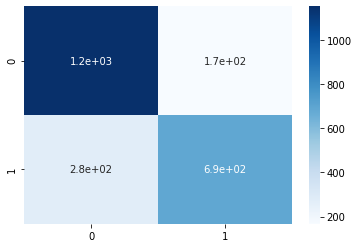

In [557]:
sns.heatmap(confusion_matrix(y_val,y_preds),annot=True,cmap='Blues')

### Find the number of false positives and false negatives

### Our first attempt got a validation accuracy of 79.78%

I will go back and clean the data better, and also make bigram and trigram models. However, it will be interesting to create a few examples and see what the classifier predicts.

### New tweet classifier

In [558]:
def classify_text(text):
    text_counts = counter.transform([text]).toarray()
    prediction_probabilities = nb_classifier.predict_proba(text_counts)[0]
    classes = ['not a disaster', 'disaster']
    
    if prediction_probabilities[0] > prediction_probabilities[1]:
        classification = classes[0]
    else:
        classification = classes[1]
    
    print("""Probability it's not a disaster: %.2f \nProbability it's a disaster: %.2f. \nClassification: %s
    """ % (prediction_probabilities[0],prediction_probabilities[1],classification) )
    
    

In [559]:
classify_text('you have a friendly friend in me')

classify_text('There is a fire in my bathroom help')

Probability it's not a disaster: 0.94 
Probability it's a disaster: 0.06. 
Classification: not a disaster
    
Probability it's not a disaster: 0.72 
Probability it's a disaster: 0.28. 
Classification: not a disaster
    


In [560]:
classify_text('Rick and Sid living together')

Probability it's not a disaster: 0.83 
Probability it's a disaster: 0.17. 
Classification: not a disaster
    


In [561]:
classify_text('I am brushing my teeth')

Probability it's not a disaster: 0.97 
Probability it's a disaster: 0.03. 
Classification: not a disaster
    


## Building a Random Forest Classifier Using Location Data and NB_Classifier Probabilities

In addition to the text data, we also have location data. However, there are around 3000 different locations included, some corresponding to the same place (for example US, USA, America). To further complicate matters, some locations are just given as cities. Due to time limitations, and diminishing numbers of entries for some locations, I will only bother with the top 10 or so countries and as many variants as I can think of. I may also include 10 major cities and 5 large US states. These will all be one-hot-encoded, in addition to prediction probabilities obtained from the naive Bayes classifier. 

## Things to do:

Add a new data column to the model including the proportion of the keywords that correspond to real disasters. That way we can collapse over 200 categorical entries into a number between 0 and 1.


In [562]:
#seeing some of the top locations
tweets['location'].value_counts()[0:60];

In [563]:
#including as many alternative mentions of the same country as possible
#can't indlude US in America's list as it appears in too many words for the method we will use 
america = ['usa','america','united states','united states of america','new york','los angeles','chicago',
          'california','washington','san francisco','seattle','nyc','texas','new york city','tx','ga','colorado',
          'atlanta','san diego']
britain = ['great britain','uk','united kingdom','london','manchester','birmingham','scotland','wales','england'
          ,'northern ireland']
india = ['india','mumbai','delhi','bangalore']
australia = ['australia','aus','sydney','melbourne','canberra']
canada = ['canada','toronto','montreal','vancouver']
nigeria = ['nigeria','lagos','kano','ibadan']
south_africa = ['south africa','cape town','johannesburg','durban','pretoria']
kenya = ['kenya','nairobi','mombasa','njoro']
ireland = ['ireland','dublin','cork']

#including major cities as an alternative category
major_cities = ['new york','nyc','new york city','ny','london','los angeles','toronto','mumbai','houston','seattle'
               ,'chicago','sydney','manchester','atlanta','san diego','lagos','melbourne','vancouver','cape town',
               'johannesburg','dehli','dublin']

#including major us states with sufficient representation / can't include contraction CA as it appears in too many words
major_states = ['california','new york','ny','texas','tx','tennessee','tn','georgia','ga','colorado','co',
               'washington','wa','dc']

#for any location not contained in these lists, they will go into another category labelled other.




In [564]:
#creating a new dataframe with new binary valued columns corresponding to locations contained in any of the lists
tweets_modified = tweets[['location','text','target']]

# creating the new columns
locations = ['america','britain','india','australia','canada','nigeria','south_africa','kenya',
                  'ireland','major_cities','major_states']
location_lists = [america,britain,india,australia,canada,nigeria,south_africa,kenya,
                  ireland,major_cities,major_states]
location_dict = {locations[i]: location_lists[i] for i in range(len(location_lists))}

#make the columns empty for now
for location in locations:
    tweets_modified[location] = 0
    
    
#a function that returns 1 if the location is contained in one of the provided lists, 0 otherwise
def location_confirmer(loc,related_places):
    #check that the location is not nan
    if type(loc)==float:
        return 0
    else:
        #go through all specified related places list and confirm if part of the provided location 'loc' matches this
        count = 0
        for place in related_places:
            #check it this way as some locations can have a mixture of place names
            if place in loc.lower():
                count += 1
            else: 
                pass

        #produce a binary output, 1.0 means the location is in the list of related places
        if count > 0:
            return 1
        else:
            return 0

#filling in the new columns
count = 0
for location in location_dict:
    location_list = location_dict[location]
    tweets_modified[location] = tweets_modified['location'].apply(location_confirmer,args=(location_list,))

In [565]:
#adding a prediction column along with prediction probability
def text_disaster_proba(text):
    text_counts = counter.transform([text]).toarray()
    prediction_probabilities = nb_classifier.predict_proba(text_counts)[0]

    return prediction_probabilities[1]


def text_predicted_label(text):
    text_counts = counter.transform([text]).toarray()
    
    return nb_classifier.predict(text_counts)[0]

tweets_modified['predicted_label'] = tweets_modified['text'].apply(text_predicted_label)
tweets_modified['disaster_probability'] = tweets_modified['text'].apply(text_disaster_proba)

#reorganising the columns
tweets_modified = tweets_modified[['location', 'text','america', 'britain', 'india',
       'australia', 'canada', 'nigeria', 'south_africa', 'kenya', 'ireland',
       'major_cities', 'major_states', 'predicted_label',
       'disaster_probability','target']]

In [573]:
classify_text('was in nyc last week')

Probability it's not a disaster: 0.43 
Probability it's a disaster: 0.57. 
Classification: disaster
    


In [574]:
#checking false positives
tweets_modified[tweets_modified['predicted_label']==1][tweets_modified['target']==0]['text'].head()

7     i am on top of the hill and i can see a fire in the woods.                                                            
31     wholesale markets ablaze                                                                                             
51    man wife get six years jail for setting ablaze niece                                                                  
56    truck ablaze : r21. voortrekker ave. outside or tambo intl. cargo section.                                            
63     steve these fires out here are something else. california is a tinderbox   and this clown was setting my hood ablaze 
Name: text, dtype: object

In [575]:
#checking false negatives
tweets_modified[tweets_modified['predicted_label']==0][tweets_modified['target']==1]['text'].head()

7     i am on top of the hill and i can see a fire in the woods.                                                            
31     wholesale markets ablaze                                                                                             
51    man wife get six years jail for setting ablaze niece                                                                  
56    truck ablaze : r21. voortrekker ave. outside or tambo intl. cargo section.                                            
63     steve these fires out here are something else. california is a tinderbox   and this clown was setting my hood ablaze 
Name: text, dtype: object

In [577]:
tweets_modified[tweets_modified['america']==1].head()

,location,text,america,britain,india,australia,canada,nigeria,south_africa,kenya,ireland,major_cities,major_states,predicted_label,disaster_probability,target
55,USA,kurds trampling on turkmen flag later set it ablaze while others vandalized offices of turkmen front in diyala,1,0,0,0,0,0,0,0,0,0,0,1,0.999553,1
64,"Calgary, AB",nowplaying: rene ablaze and ian buff magnitude edm,1,0,0,0,0,0,0,0,0,0,1,0,0.001708,0
66,San Francisco,what time does your talk go until. i don't know if i can make it due to work.,1,0,0,0,0,0,0,0,0,0,1,0,0.000057,0
83,"Arlington, TX",truckcrash overturns on fortworth interstate click here if you've been in a crash gt,1,0,0,0,0,0,0,0,0,0,1,1,0.824953,1
124,United States,gt gt $15 aftershock : protect yourself and profit in the next global financial. book,1,0,0,0,0,0,0,0,0,0,0,0,0.036687,0


In [589]:
#check the two dataframes are equal so that the results of sentiment_df can be appended
tweets_modified['text'].equals(sentiment_df['text']); #evaluates to true

#adding the polarity and subjectivity scores
tweets_modified[['polarity','subjectivity']] = sentiment_df[['polarity','subjectivity']]

In [639]:
#split the new modified data into training and validation samples
Xm = tweets_modified[locations + ['predicted_label','disaster_probability','polarity','subjectivity']]
ym = tweets_modified['target']

Xm_train, Xm_val, ym_train, ym_val = train_test_split(Xm,ym,test_size=0.3,random_state=12)

#creating a random forest model for the new data
#low max depth to preventh overfitting, which occurs greatly when we include the disaster_probability
forest = RandomForestClassifier(max_depth=7) 

#fit the random forest
forest.fit(Xm_train,ym_train)

#accuracy of the forest classifier
forest.score(Xm_train,ym_train), forest.score(Xm_val,ym_val)

(0.8680803152561456, 0.8559544658493871)

In [641]:
feature_importances = forest.feature_importances_

feat_imp = pd.DataFrame([feature_importances,locations + ['predicted_label','disaster_probability',
                                                          'polarity','subjectivity']]).transpose()
feat_imp.columns = ['Feature Importance','Feature']
feat_imp.sort_values(by='Feature Importance',ascending=False,inplace=True)

#creating a plot of the feature importance
fig = px.bar(feat_imp, y='Feature Importance', x='Feature', title='Importance of Included Features',
             color='Feature Importance', opacity=0.85)
fig.update_layout(uniformtext_minsize=8, uniformtext_mode='hide',showlegend=False)
fig.show()

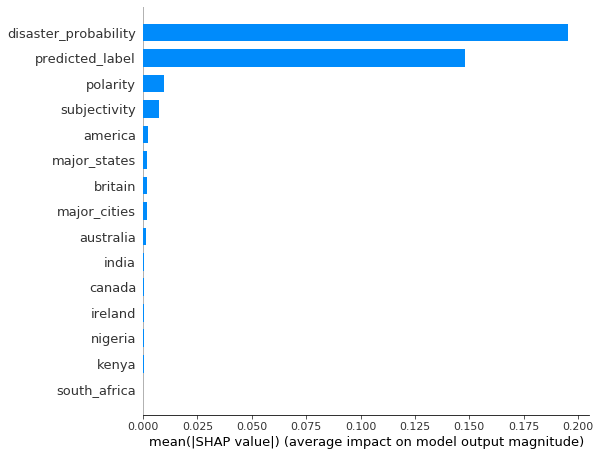

In [690]:
explainer = shap.TreeExplainer(forest)
shap_values = explainer.shap_values(Xm_train)

shap.summary_plot(shap_values[1],Xm_train,plot_type='bar')

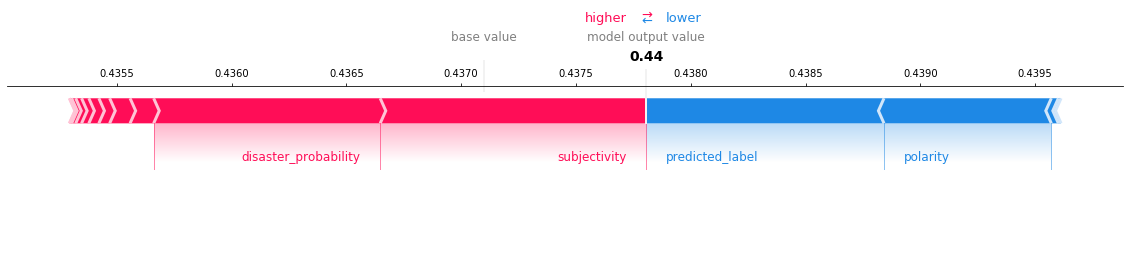

In [691]:
shap.force_plot(explainer.expected_value[1],shap_values[0].mean(axis=0),Xm_train.columns,matplotlib=True)

In [666]:
explainer.expected_value

array([0.56289923, 0.43710077])

In [684]:
shap_values[0].mean(axis=0)

(15,)

In [46]:
#check how many false positives and false negatives exist and how many have at least one non zero entry in the above
#categories. If the number is small, perhaps we can resample to create a stronger signal

In [47]:
sum(feature_importances[0:-2])

0.022405849348707964

# Things to do:

Look at some false positives and false negatives for the first model, and some tha have been corrected by the second model.

Include sentiment analysis polarity and subjectivity data in the dataframe so that the random forest can learn from them.